In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import re

sns.set_theme()

In [6]:
def get_metrics(
        logs_path,
        hist_stats_names=("policy_main_reward", "win_rate", "final_score_0", "final_score_1", "undesirable_action_0")
):
    files = [os.path.join(logs_path, f) for f in os.listdir(logs_path) if os.path.isfile(os.path.join(logs_path, f)) and f.startswith('result_iteration_')]
    files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    hist_stats = defaultdict(list)
    for file in files:
        with open(file) as f:
            d = json.load(f)
            for hist_stat in hist_stats_names:
                if hist_stat not in d["env_runners"]["hist_stats"]:
                    continue
                hist_stats[hist_stat].append(np.array(d["env_runners"]["hist_stats"][hist_stat]))
                hist_stats[hist_stat+"_mean"].append(np.mean(hist_stats[hist_stat][-1]))
                hist_stats[hist_stat+"_min"].append(np.mean(hist_stats[hist_stat][-1]))
                hist_stats[hist_stat+"_max"].append(np.mean(hist_stats[hist_stat][-1]))

    return hist_stats

In [7]:
# Add all paths to the experiments here
logs_to_evaluate = [
    "logs/grid_search/obs_simple_indirect_True_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[32]",
    # "logs/grid_search/obs_simple_indirect_True_vf_True_cr_5.0_ar_5_decay_1_ent_0.01_nn_[512, 256, 128]",
    #"logs/self_play/obs_eff_one_hot_indirect_True_vf_True_cr_5_ar_1_decay_0.996_ent_0.03_nn_[32, 32]_sebischeme",
    #"logs/self_play/obs_eff_one_hot_indirect_True_vf_True_cr_5_ar_1_decay_0.995_ent_0.03_nn_[64, 64]_sebischeme",
    #"logs/self_play/obs_simple_indirect_True_vf_True_cr_5_ar_1_decay_0.995_ent_0.03_nn_[64]_sebischeme",
    #"logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[2048, 2048, 1024, 512]_af_tanh",
    #"logs/self_play/obs_simple_indirect_True_vf_True_cr_5_ar_1_decay_1_ent_0.03_nn_[32]_sebischeme",
    #"logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[256, 256]_af_relu"

]

all_hist_stats = []
for log_path in logs_to_evaluate:
    all_hist_stats.append(get_metrics(log_path))

plt.rcParams["figure.figsize"] = (12, 8)

In [17]:
# Print mean mean final score over last 100 iterations
for i, log_path in enumerate(logs_to_evaluate):
    mean_final_score = np.mean(all_hist_stats[i]["final_score_0_mean"][-100:])
    mean_win_rate = np.mean(all_hist_stats[i]["win_rate"][-100:])
    undesirable_actions = np.mean(all_hist_stats[i]["undesirable_action_0"][-100:])
    print(f"{log_path} - Final Score: {mean_final_score}")
    print(f"{log_path} - Win Rate: {mean_win_rate}")
    print(f"{log_path} - Undesirable Actions: {undesirable_actions}")

logs/grid_search/obs_simple_indirect_True_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[32] - Final Score: 26.358299999999996
logs/grid_search/obs_simple_indirect_True_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[32] - Win Rate: 0.4266
logs/grid_search/obs_simple_indirect_True_vf_True_cr_0_ar_1_decay_1_ent_0.03_nn_[32] - Undesirable Actions: 16.1729


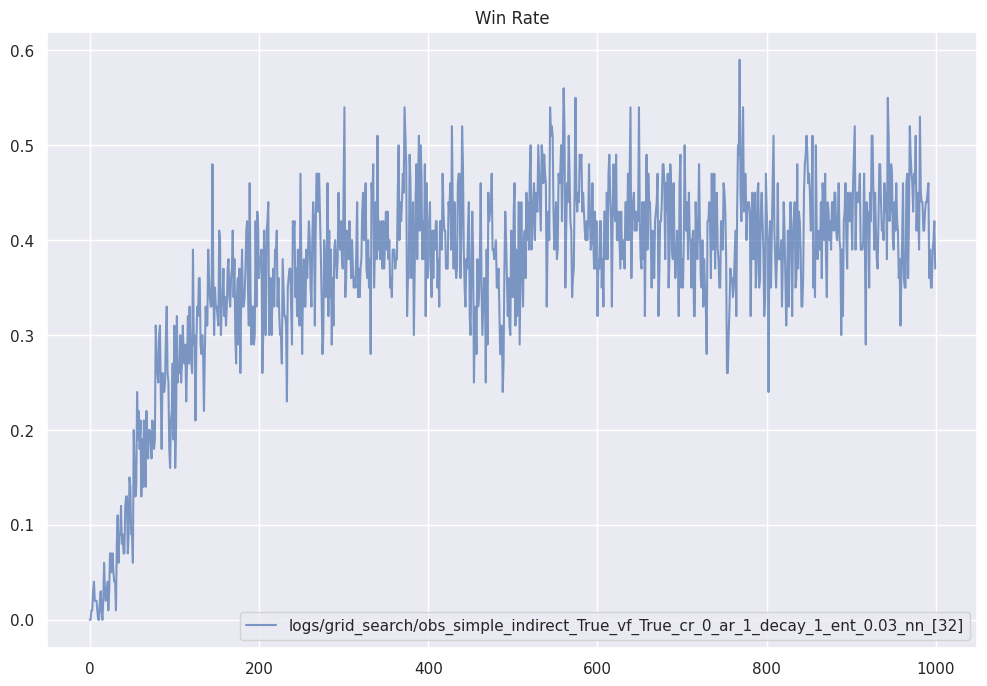

In [9]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["win_rate_mean"], label=logs, alpha=0.7)
plt.title("Win Rate")
plt.legend()
plt.show()

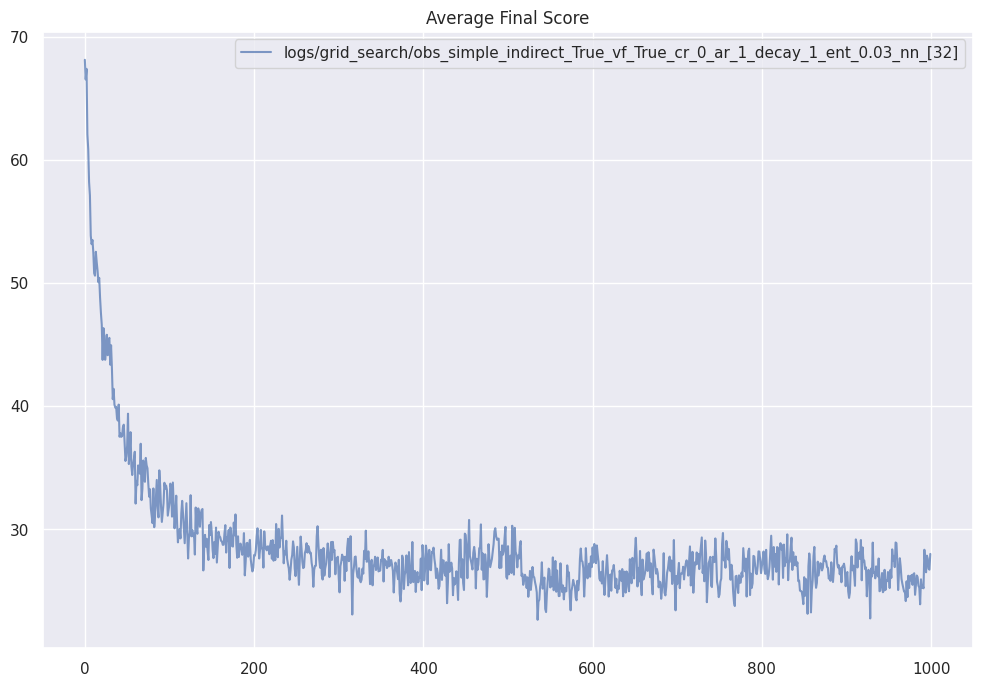

In [10]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["final_score_0_mean"], label=logs, alpha=0.7)
plt.title("Average Final Score")
plt.legend()
plt.show()

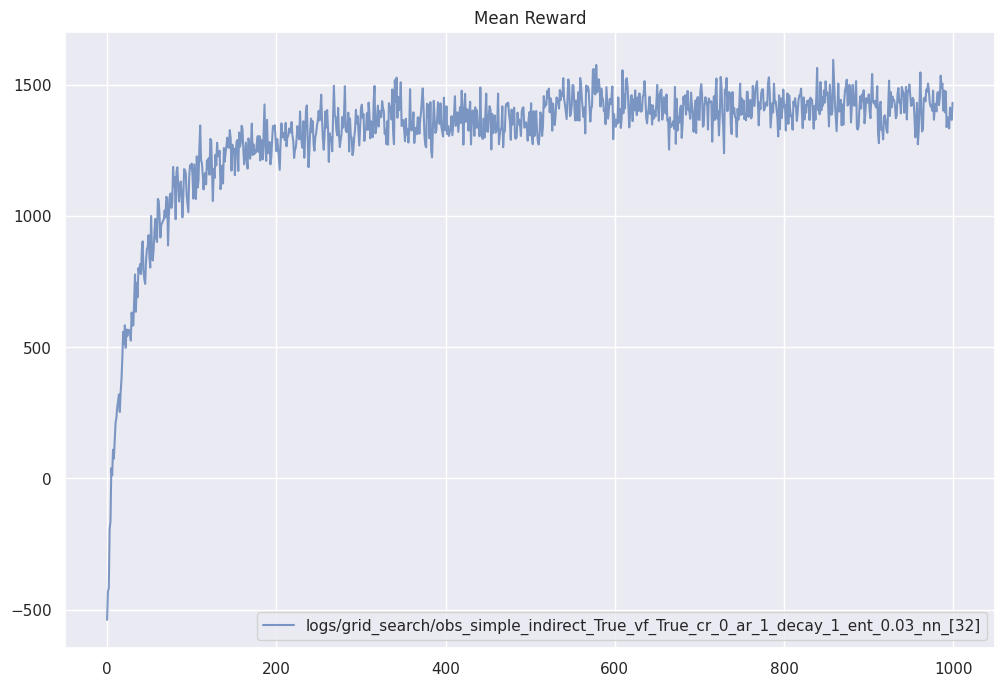

In [11]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["policy_main_reward_mean"], label=logs, alpha=0.7)
plt.title("Mean Reward")
plt.legend()
plt.show()

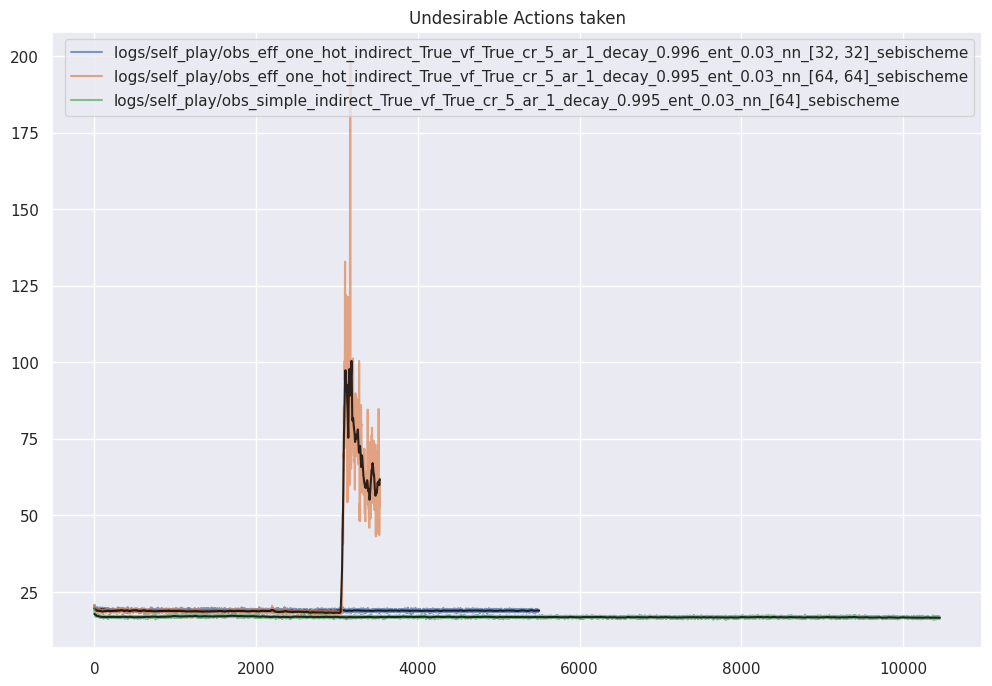

In [57]:
plt.show()
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    undes_actions = hist_stats["undesirable_action_0_mean"]
    N =len(undes_actions)
    mean_undes_actions = np.zeros(N)
    for i in range(N):
        if i < 20:
            mean_undes_actions[i] = np.mean(undes_actions[:i+20])
        elif (i+20) >= N:
            mean_undes_actions[i] = np.mean(undes_actions[i-20:])
        else:
            mean_undes_actions[i] = np.mean(undes_actions[i-20:i+20])
    sns.lineplot(hist_stats["undesirable_action_0_mean"], label=logs, alpha=0.7)
    sns.lineplot(mean_undes_actions, alpha=0.8, c = "black")
plt.title("Undesirable Actions taken")
plt.legend()
plt.show()